<a href="https://colab.research.google.com/github/Danata117/ML/blob/main/ML_Praktika5_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [ ]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

In [ ]:
# Базовые импорты
import pandas as pd
import numpy as np


In [30]:

import sqlite3
conn = sqlite3.connect("vladivostok_news.db")
df = pd.read_sql_query("SELECT * FROM articles;", conn)
conn.close()

In [ ]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

Пояснения к датасету:

Данная база данных содержит информацио о статьях и сами статьи с сайта newsvl.ru.

guid - уникальный идентификатор записи, тип UUID v4

title - текстовый заголовок

description	- текст статьи

url - ссылка на статью

published_at - Дата публикации (без времени)

comments_count - количество комментариев (на сайте newsvl.ru нет комментариев, поэтому кол-во равно нулю по умолчанию)

created_at_utc - время сохранения в базу данных

rating - рейтинг (его нет на сайте, None по умолчанию)

word_count - кол-во слов в статье

In [31]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,word_count
0,b78c12f4-2675-4bce-9ec2-d9f6a645734e,«Стоимость проезда должна равняться литру топл...,Под конец года перевозчики подали обращение в ...,https://www.newsvl.ru/vlad/2025/12/18/235760/,2025-12-18 00:00:00,0,2025-12-19 01:57:54,None,404
1,665826ae-66ba-44aa-a98c-2d16e77aecf7,«Киллер белорусского плавания»: пловец с наруш...,Четыре заплыва и четыре золотые медали – 17-ле...,https://www.newsvl.ru/sport/2025/12/18/235759/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,863
2,2527cd1b-0401-42d4-ac18-3c2e7fac567b,Сегодня во Владивостоке до +3 °С,"Во Владивостоке в пятницу, 19 декабря, утром н...",https://www.newsvl.ru/vlad/2025/12/19/235761/,2025-12-19 00:00:00,0,2025-12-19 01:57:55,None,50
3,87b78abb-95cb-4f51-93ce-85521ba026d6,Во Владивостоке подключили камеры для штрафов ...,Во Владивостоке установили и подключили компле...,https://www.newsvl.ru/vlad/2025/12/18/235758/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,441
4,ada7970c-53ad-4d47-ac25-1b6e94d39341,"На Шилкинской, возможно, закроют ещё одну авто...","Участок на Шилкинской, 21 во Владивостоке, где...",https://www.newsvl.ru/vlad/2025/12/18/235756/,2025-12-18 00:00:00,0,2025-12-19 01:57:55,None,485


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            5000 non-null   object
 1   title           5000 non-null   object
 2   description     5000 non-null   object
 3   url             5000 non-null   object
 4   published_at    5000 non-null   object
 5   comments_count  5000 non-null   int64 
 6   created_at_utc  5000 non-null   object
 7   rating          0 non-null      object
 8   word_count      5000 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 351.7+ KB


Приведём строковые даты к datetime, чтобы с ними можно было работать как с временными признаками.

In [33]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df["created_at_utc"] = pd.to_datetime(df["created_at_utc"], errors="coerce")

df[["published_at", "created_at_utc"]].head()

,published_at,created_at_utc
0,2025-12-18,2025-12-19 01:57:54
1,2025-12-18,2025-12-19 01:57:55
2,2025-12-19,2025-12-19 01:57:55
3,2025-12-18,2025-12-19 01:57:55
4,2025-12-18,2025-12-19 01:57:55


## Предобработка

In [34]:
import re
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
import nltk

nltk.download("stopwords")

morph = MorphAnalyzer()

STOP_RU = set(stopwords.words("russian"))
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)

def preprocess_text(text: str):
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in STOP_RU:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in STOP_RU:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas


tokenized_texts = df["description"].astype(str).apply(preprocess_text).tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

Под конец года перевозчики подали обращение в администрацию Владивостока с просьбой установить эконо ...


['конец',
 'год',
 'перевозчик',
 'подать',
 'обращение',
 'администрация',
 'владивосток',
 'просьба',
 'установить',
 'экономически',
 'обоснованный',
 'тариф',
 'проезд',
 'подписаться',
 'обращение',
 'объяснять',
 'топливо',
 'запчасть',
 'аренда',
 'подорожать',
 'автобус',
 'работать',
 'минус',
 'расча',
 'тный',
 'тариф',
 'учитывать',
 'затрата',
 'составить',
 'менее',
 'рубль',
 'компания',
 'понимать',
 'столько',
 'проезд',
 'стоить',
 'мэрия',
 'искать',
 'компромисс',
 'предприниматель',
 'пассажир',
 'январь',
 'владивосток',
 'повысить',
 'стоимость',
 'проезд',
 'автобус',
 'рубль',
 'зависимость',
 'способ',
 'оплата',
 'администрация',
 'объяснить',
 'решение',
 'принять',
 'рассмотрение',
 'экономический',
 'расча',
 'тов',
 'компания',
 'перевозчик',
 'лето',
 'автобусник',
 'вновь',
 'попросить',
 'поднять',
 'тариф',
 'рубль',
 'обращение',
 'подписаться',
 'компания',
 'например',
 'самокат',
 'считать',
 'перекладывать',
 'пассажир',
 'нужный',
 'брутто',
 'к

In [36]:
N_DOCS = 5000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['конец',
 'год',
 'перевозчик',
 'подать',
 'обращение',
 'администрация',
 'владивосток',
 'просьба',
 'установить',
 'экономически',
 'обоснованный',
 'тариф',
 'проезд',
 'подписаться',
 'обращение',
 'объяснять',
 'топливо',
 'запчасть',
 'аренда',
 'подорожать',
 'автобус',
 'работать',
 'минус',
 'расча',
 'тный',
 'тариф',
 'учитывать',
 'затрата',
 'составить',
 'менее',
 'рубль',
 'компания',
 'понимать',
 'столько',
 'проезд',
 'стоить',
 'мэрия',
 'искать',
 'компромисс',
 'предприниматель']

## Обучение модели

In [40]:
from gensim.models import Word2Vec
import numpy as np

w2v = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
doc_vectors.shape


(5000, 100)

In [43]:
w2v.wv.most_similar("пробка", topn=10)

[('затор', 0.8538477420806885),
 ('сковать', 0.7263122200965881),
 ('автомобилист', 0.6928849816322327),
 ('дальхимпром', 0.6870032548904419),
 ('перекрываться', 0.6843724846839905),
 ('выделенка', 0.6839950084686279),
 ('сткома', 0.6821685433387756),
 ('поворачивать', 0.681422770023346),
 ('стояние', 0.6806368827819824),
 ('полоса', 0.6728419661521912)]

In [45]:
for test_word in ["пробка", "администрация", "автобус", "владивосток", "кожемяко"]:
    if test_word not in w2v.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")


Похожие слова для «пробка»:
  затор           0.854
  сковать         0.726
  автомобилист    0.693
  дальхимпром     0.687
  перекрываться   0.684

Похожие слова для «администрация»:
  мэрия           0.769
  замглавы        0.686
  поручать        0.652
  умс             0.638
  мцу             0.634

Похожие слова для «автобус»:
  маршрутка       0.774
  перевозчик      0.740
  маршрут         0.737
  паз             0.715
  маз             0.713

Похожие слова для «владивосток»:
  город           0.656
  вторник         0.627
  четверг         0.617
  бракосочетание  0.609
  анонсироваться  0.594

Похожие слова для «кожемяко»:
  губернатор      0.841
  олег            0.775
  трутнеть        0.724
  миклушевский    0.707
  врио            0.706


In [48]:
def document_vector(tokens, model: Word2Vec):

    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v) for tokens in tokenized_texts])
doc_vectors.shape

(5000, 100)

In [49]:

doc_vectors[:3]

array([[ 4.16273996e-02,  2.56323040e-01, -2.06547916e-01,
         9.47911106e-03,  1.02537572e-01, -1.33733720e-01,
        -2.23254617e-02,  4.48860675e-01, -1.20485649e-01,
        -2.93396980e-01,  8.96195769e-02, -2.42196992e-01,
        -2.22315699e-01,  8.81552100e-02, -4.06107195e-02,
        -3.80569063e-02, -2.56607775e-02, -7.10322708e-02,
        -5.40241040e-03, -6.17309809e-01,  9.16150138e-02,
         9.48488042e-02,  1.26234889e-01, -2.81218383e-02,
         1.74693301e-01, -7.51037672e-02, -1.93768322e-01,
         4.65633981e-02, -2.60217011e-01, -1.04690343e-02,
         6.36670291e-02, -1.97041333e-01, -6.83145970e-02,
        -2.58445472e-01,  1.24576733e-01,  5.78108355e-02,
         1.33170888e-01, -2.10502103e-01, -3.03097758e-02,
        -3.55263382e-01,  1.41474511e-02, -1.33156568e-01,
        -2.05667898e-01,  3.03792935e-02,  1.83096275e-01,
        -2.91249990e-01, -2.15038091e-01, -1.12016156e-01,
        -6.52861148e-02,  8.46467167e-02,  2.05669090e-0

In [51]:
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,word_count,pca_x,pca_y
0,b78c12f4-2675-4bce-9ec2-d9f6a645734e,«Стоимость проезда должна равняться литру топл...,Под конец года перевозчики подали обращение в ...,https://www.newsvl.ru/vlad/2025/12/18/235760/,2025-12-18,0,2025-12-19 01:57:54,None,404,0.295235,-0.184466
1,665826ae-66ba-44aa-a98c-2d16e77aecf7,«Киллер белорусского плавания»: пловец с наруш...,Четыре заплыва и четыре золотые медали – 17-ле...,https://www.newsvl.ru/sport/2025/12/18/235759/,2025-12-18,0,2025-12-19 01:57:55,None,863,0.249408,-0.009704
2,2527cd1b-0401-42d4-ac18-3c2e7fac567b,Сегодня во Владивостоке до +3 °С,"Во Владивостоке в пятницу, 19 декабря, утром н...",https://www.newsvl.ru/vlad/2025/12/19/235761/,2025-12-19,0,2025-12-19 01:57:55,None,50,-1.809638,0.929643
3,87b78abb-95cb-4f51-93ce-85521ba026d6,Во Владивостоке подключили камеры для штрафов ...,Во Владивостоке установили и подключили компле...,https://www.newsvl.ru/vlad/2025/12/18/235758/,2025-12-18,0,2025-12-19 01:57:55,None,441,0.176347,0.058749
4,ada7970c-53ad-4d47-ac25-1b6e94d39341,"На Шилкинской, возможно, закроют ещё одну авто...","Участок на Шилкинской, 21 во Владивостоке, где...",https://www.newsvl.ru/vlad/2025/12/18/235756/,2025-12-18,0,2025-12-19 01:57:55,None,485,0.332805,0.039557


Построим scatter-график всех документов в пространстве первых двух главных компонент.

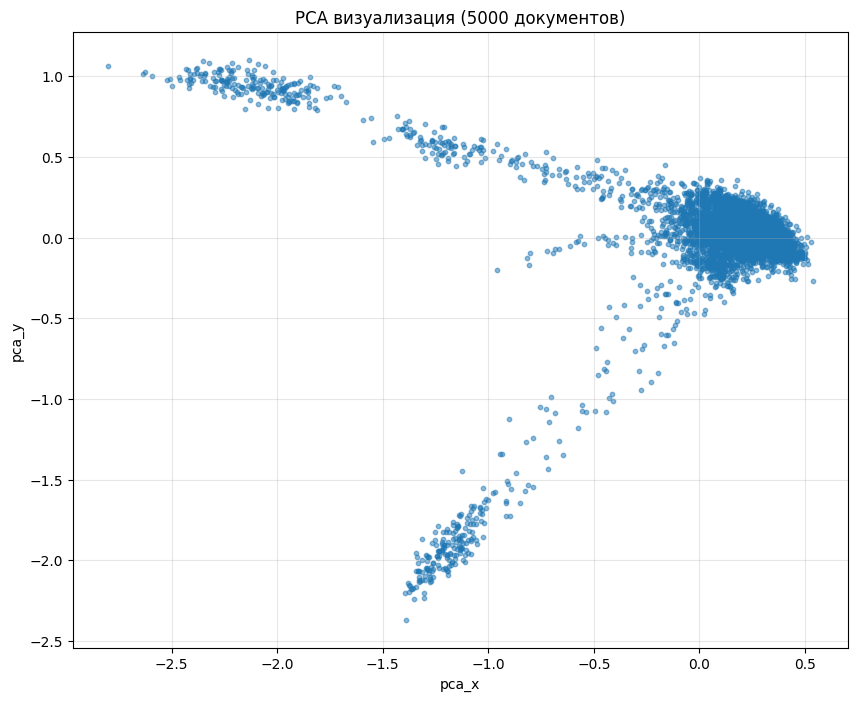

In [54]:
import matplotlib.pyplot as plt

# Самый простой способ
df_subset.plot(kind='scatter', x='pca_x', y='pca_y',
               figsize=(10, 8), alpha=0.5, s=10)
plt.title(f"PCA визуализация ({len(df_subset)} документов)")
plt.grid(True, alpha=0.3)
plt.show()

## Кластеризация


In [ ]:
# В этом блоке подобрать метод кластеризации
# В df записать новую колонку clusfer

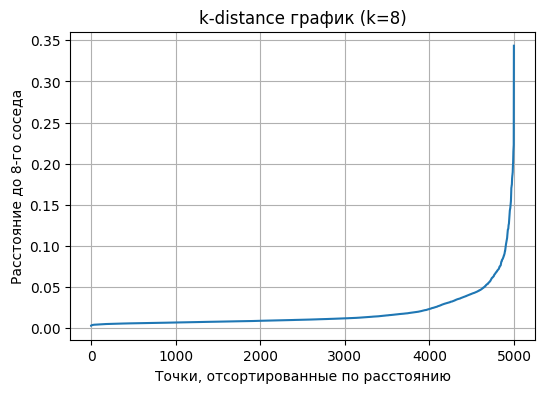

In [55]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 8  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()

In [56]:
dbscan = DBSCAN(eps=0.010, min_samples=8)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([2052, 2615,   20,   27,   19,   15,   11,   16,   21,   12,   12,
          14,   12,   13,    8,    8,   10,   24,    9,    9,   10,    8,
           7,   11,    8,    7,    3,    8,    8,    3]))

In [57]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

,title,cluster
0,«Стоимость проезда должна равняться литру топл...,-1
1,«Киллер белорусского плавания»: пловец с наруш...,0
2,Сегодня во Владивостоке до +3 °С,-1
3,Во Владивостоке подключили камеры для штрафов ...,0
4,"На Шилкинской, возможно, закроют ещё одну авто...",0
5,"Рыбный рынок, «лёгкое метро» и пробки на дорог...",0
6,На трассе от «Восточной верфи» до съезда на ос...,0
7,Резиденты офшорной зоны на Русском острове пож...,0
8,Администрация Владивостока заказывает проекты ...,0
9,BMW опрокинулся на острове Русском рядом с кам...,12


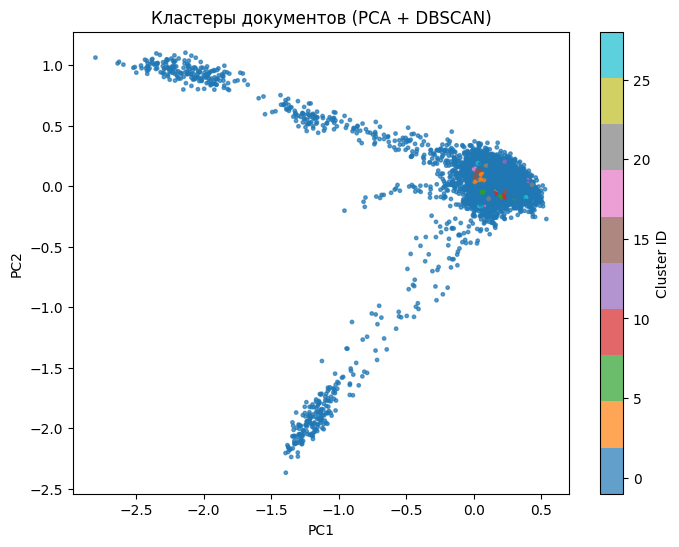

In [58]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [64]:
cluster_id = 3

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
122,В пристройке «Концерт Холла» сгорела студия зв...
138,На Де-Фризе загорелся полуприцеп китайского гр...
1134,«Запись вся сформирована»: на шиномонтажах Вла...
1359,Основной выезд из Раздольного в сторону Уссури...
2125,Акватория вокруг Владивостока внезапно опустел...
2193,"Йога, сальса и регби: анонсы событий во Владив..."
2372,Яхтсмены из Владивостока получили 23 медали на...
2481,"SUP FEST, «Гонка героев», GUF: анонсы событий ..."
2527,В понедельник часть жителей Владивостока остан...
2730,Инфляция в Приморье обогнала общероссийскую на...


## Обработка признаков

In [68]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()

Всего объектов для supervised-задачи: 2948 из 5000


,count
cluster,
0,2615
1,20
2,27
3,19
4,15
5,11
6,16
7,21
8,12


In [69]:
from sklearn.impute import SimpleImputer

num_cols = ["comments_count", "rating"]  # числовые фичи
numeric = df_sup[num_cols].values

imputer = SimpleImputer(strategy="median")
numeric_imputed = imputer.fit_transform(numeric)
numeric_imputed.shape


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning:

Skipping features without any observed values: [1]. At least one non-missing value is needed for imputation with strategy='median'.



(2948, 1)

In [70]:
# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X = np.hstack([doc_vectors_sup, numeric_imputed])
X.shape

(2948, 101)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((2358, 101), (590, 101))

In [72]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Предсказать кластеры методом DecisionTree

In [74]:
dt_clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
)


dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

Decision Tree accuracy: 0.8711864406779661

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       523
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Предсказать кластеры методом KNN

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Базовый классификатор (без фиксированных гиперпараметров)
knn_base = KNeighborsClassifier()

# Сетка гиперпараметров для перебора
param_grid = {
    "n_neighbors": [3, 5, 10, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "euclidean"],
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # использовать все доступные ядра
    verbose=1,     # чтобы видеть прогресс
)


grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший CV accuracy:", grid_knn.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'uniform'}
Лучший CV accuracy: 0.8897369462737054


In [77]:
best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("k-NN (best) accuracy на тесте:", accuracy_score(y_test, y_pred_knn))
print("\nClassification report (k-NN best):")
print(classification_report(y_test, y_pred_knn))

k-NN (best) accuracy на тесте: 0.888135593220339

Classification report (k-NN best):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       523
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

